In [351]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import plot_importance, plot_tree
#import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Exclude boolean columns (location_A, location_B, location_C)
# columns_to_scale = x_train.columns.difference(['location_A', 'location_B', 'location_C'])

# scaler = MinMaxScaler()
# x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
# x_test[columns_to_scale] = scaler.transform(x_test[columns_to_scale])


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

- Modeller: XGBooost, LightGBM, SARIMA + autots
- sjekke feature importance
- fjerne de som ikke hjelper
- sjekk seasonality
- Legge til sinus, cosinus, lag-features, rolling mean
- Sjekke forbedringer

I have the following features in my dataset. I am training a trying to do a time series forecast on solar production, training a machine learning model. Looking at feature engineering. Consider the features below, and tell me if adding a lag feature and/or rolling_mean feature from each of the features below will make sense.
- elevation: elevation of ground above sea level [m]
- Direct rad W: direct radiation flux [W/m2]

In [352]:
x_train_df = pd.read_csv("cleaned_and_combined_data/x_train_combined.csv")
y_train_df = pd.read_csv("cleaned_and_combined_data/y_train_combined.csv")
x_test_df = pd.read_csv("cleaned_and_combined_data/x_test_combined.csv")


In [353]:
split_index = int(0.75 * len(x_train_df))

# Split the data into training and validation sets
x_train = x_train_df[:split_index]
y_train = pd.DataFrame(y_train_df["pv_measurement"][:split_index])
x_valid = x_train_df[split_index:]
y_valid = pd.DataFrame(y_train_df["pv_measurement"][split_index:])

In [354]:
xgbr = xgb.XGBRegressor(n_estimators=2000)
xgbr.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

predictions = pd.DataFrame()
predictions["preds"] = xgbr.predict(x_valid)

mean_absolute_error(y_true=y_valid["pv_measurement"],
                   y_pred=predictions['preds'])


/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_b

119.66408278816118

## Print feature importances

In [366]:
feature_names = x_train.columns

def get_feature_importances(model_name):
    importances = model_name.feature_importances_
    return importances
    

xbgr_f_importances = get_feature_importances(xgbr)

# Sort feature importances in descending order and get the index

def plot_feature_importances(f_importance_list):
    indices = np.argsort(f_importance_list)[::-1]

    # Create a plot
    plt.figure(figsize=(10, 10))
    plt.title("Feature Importances")
    plt.barh(range(x_train.shape[1]), f_importance_list[indices], align="center")
    plt.yticks(range(x_train.shape[1]), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.show()

#plot_feature_importances(xbgr_f_importances)
print(xbgr_f_importances)


[4.2871041e-03 3.7289280e-03 7.0591029e-03 6.1188759e-03 3.2407001e-02
 7.8700278e-03 1.0768523e-06 6.7537040e-03 5.9833556e-02 4.1782162e-03
 3.5885710e-01 4.8332741e-03 1.0509054e-02 1.6318789e-01 1.5247246e-03
 0.0000000e+00 7.5059175e-03 1.1217601e-04 1.6196994e-03 0.0000000e+00
 1.0093417e-03 7.2859880e-03 3.7623975e-02 1.0076285e-03 8.4714536e-03
 6.2731286e-03 0.0000000e+00 1.5776999e-02 8.0930693e-03 8.2887579e-03
 4.6437574e-03 5.7424890e-04 0.0000000e+00 7.2183053e-04 1.3539474e-02
 2.5281757e-02 2.5956454e-02 7.2818883e-03 9.3456926e-03 1.1736304e-02
 6.3125971e-03 8.0619203e-03 8.2327686e-03 7.0455992e-03 5.8926811e-04
 1.8288288e-02 3.0494237e-02 1.0753606e-02 3.6031969e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.9059403e-04
 0.0000000e+00]


In [356]:
#Choosing top ten features

def top_features(Number_of_features, f_importance_list):
    top_indices = np.argsort(f_importance_list)[-Number_of_features:]

    top_indices = top_indices[::-1]

    # Extract the names of the top features
    top_features = [feature_names[i] for i in top_indices]

    return top_features

top_features = top_features(15,xbgr_f_importances)

print(top_features)



['direct_rad:W', 'elevation:m', 'diffuse_rad:W', 'precip_5min:mm', 'forecast_hour', 'clear_sky_rad:W', 'forecast_month', 'sun_elevation:d', 'sun_azimuth:d', 'forecast_year', 'rain_water:kgm2', 'snow_water:kgm2', 'total_cloud_cover:p', 'forecast_day', 'effective_cloud_cover:p']


9,10,11

In [357]:
x_train_top_features = x_train[top_features]
x_valid_top_features = x_valid[top_features]

xgbr2 = xgb.XGBRegressor(n_estimators=2000)
xgbr2.fit(x_train_top_features, y_train,
        eval_set=[(x_train_top_features, y_train), (x_valid_top_features, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

predictions = pd.DataFrame()
predictions["preds"] = xgbr2.predict(x_valid_top_features)

mean_absolute_error(y_true=y_valid["pv_measurement"],
                   y_pred=predictions['preds'])

/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_b

124.88955905981123

In [358]:
'''
def train_models_on_top_features(max_features, X_train, y_train, x_valid, y_valid):
    trained_models = []

    # Train the base model to get initial feature importances
    xgbr = xgb.XGBRegressor(n_estimators=2000)
    xgbr.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=300,
    verbose=False)


    xbgr_f_importances = get_feature_importances(xgbr)

 

    for i in range(1, max_features + 1):
        # Get top i features

        features = top_features(i,xbgr_f_importances)

        # Train a new model on top i features
        model = xgb.XGBRegressor()
        x_train_f = X_train[features]
        x_valid_f = x_valid[features]
        model.fit(x_train_f, y_train, eval_set =[(x_train_f, y_train), (x_valid_f, y_valid)],early_stopping_rounds=300,
        verbose=False)

        # Save the trained model
        trained_models.append(model)

    return trained_models


def print_mae_for_models(trained_models, x_valid, y_valid):
    l = []
    for model in trained_models:
        # Ensure to use only the features present in each model for prediction
        #features = model.get_booster().feature_names
        features = model.feature_names
        # Reorder X_test columns based on the order in the trained model
        X_test_reordered = x_valid[features]
        predictions = pd.DataFrame()
        predictions["preds"] = model.predict(X_test_reordered)
        mae = mean_absolute_error(y_true=y_valid["pv_measurement"],y_pred=predictions['preds'])
        l.append(mae)
    return l

models = train_models_on_top_features(15,x_train,y_train, x_valid, y_valid)

list_mae = print_mae_for_models(models, x_valid, y_valid)

for i in range(0,len(list_mae)):
    print(f"Mae for model including {str(i)} features: {list_mae[i]:.4f}")

'''

'\ndef train_models_on_top_features(max_features, X_train, y_train, x_valid, y_valid):\n    trained_models = []\n\n    # Train the base model to get initial feature importances\n    xgbr = xgb.XGBRegressor(n_estimators=2000)\n    xgbr.fit(x_train, y_train,\n    eval_set=[(x_train, y_train), (x_valid, y_valid)],\n    early_stopping_rounds=300,\n    verbose=False)\n\n\n    xbgr_f_importances = get_feature_importances(xgbr)\n\n \n\n    for i in range(1, max_features + 1):\n        # Get top i features\n\n        features = top_features(i,xbgr_f_importances)\n\n        # Train a new model on top i features\n        model = xgb.XGBRegressor()\n        x_train_f = X_train[features]\n        x_valid_f = x_valid[features]\n        model.fit(x_train_f, y_train, eval_set =[(x_train_f, y_train), (x_valid_f, y_valid)],early_stopping_rounds=300,\n        verbose=False)\n\n        # Save the trained model\n        trained_models.append(model)\n\n    return trained_models\n\n\ndef print_mae_for_model

In [365]:
def get_top_features(Number_of_features, f_importance_list):
    top_indices = np.argsort(f_importance_list)[-Number_of_features:]
    top_indices = top_indices[::-1]
    # Extract the names of the top features
    top_feature_names = [feature_names[i] for i in top_indices]
    return top_feature_names

#selected_features = get_top_features(12, xbgr_f_importances)


def train_models_on_top_features(max_features, x_train, y_train, x_valid, y_valid):
    trained_models = {}

    xgbr = xgb.XGBRegressor(n_estimators=2000)
    xgbr.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=300,
    verbose=False)

    xbgr_f_importances = get_feature_importances(xgbr)


    for i in range(1, max_features + 1):
        # Get top i features
        features = top_features(i,xbgr_f_importances)


        # Train a new model on top i features
        model = xgb.XGBRegressor()
        x_train_f = x_train[features]
        x_valid_f = x_valid[features]
        model.fit(x_train_f, y_train, eval_set=[(x_train_f, y_train), (x_valid_f, y_valid)], early_stopping_rounds=300, verbose=False)

        # Save the trained model
        trained_models[str(i)] = model  # Use str(i) as the name of the model

    return trained_models

def print_mae_for_models(trained_models, x_valid, y_valid):
    for name, model in trained_models.items():
        features = model.get_booster().feature_names
        X_test_reordered = x_valid[features]
        predictions = model.predict(X_test_reordered)
        mae = mean_absolute_error(y_valid, predictions)
        print(f"Mae for model including {name} features: {mae:.4f}")

models = train_models_on_top_features(15, x_train, y_train, x_valid, y_valid)
print_mae_for_models(models, x_valid, y_valid)


TypeError: 'list' object is not callable

# Check what number of features the model gets best result

/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/syvernes/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_b

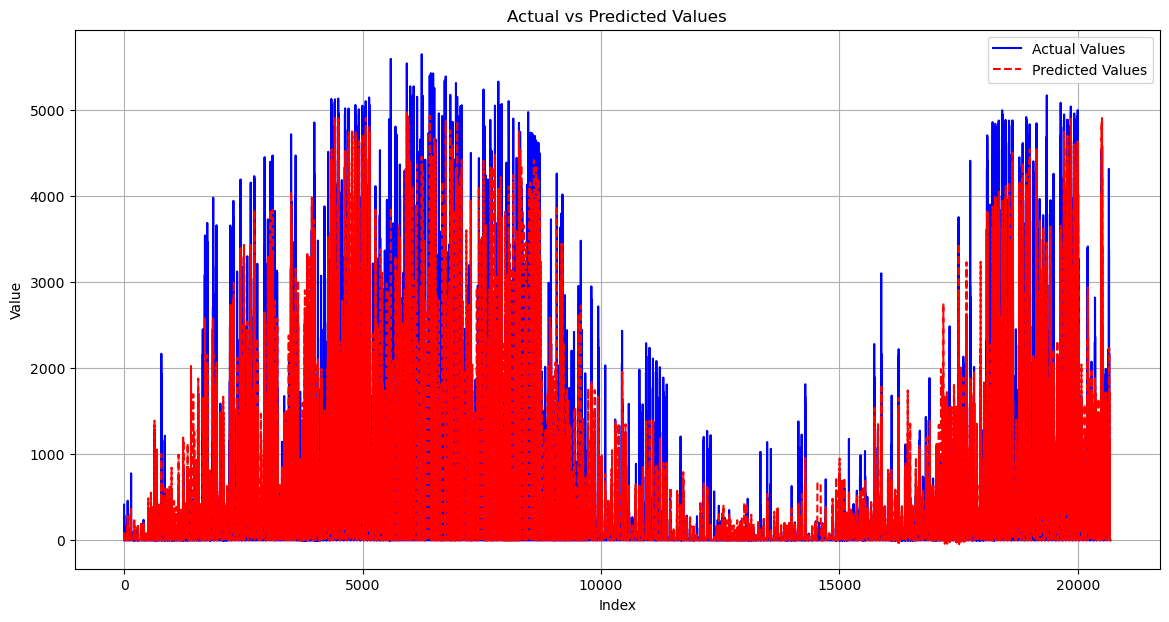

In [360]:
predictions = pd.DataFrame()
predictions["preds"] = xgbr.predict(x_valid)


plt.figure(figsize=(14, 7))

# Plotting the actual values
plt.plot(y_valid.reset_index(drop=True), label='Actual Values', color='blue')

# Plotting the predicted values
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')

plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [361]:
from autots import AutoTS
from autots.models.model_list import model_lists


In [362]:
print(model_lists)

{'all': ['ConstantNaive', 'LastValueNaive', 'AverageValueNaive', 'GLS', 'GLM', 'ETS', 'ARIMA', 'FBProphet', 'RollingRegression', 'GluonTS', 'SeasonalNaive', 'UnobservedComponents', 'VECM', 'DynamicFactor', 'MotifSimulation', 'WindowRegression', 'VAR', 'DatepartRegression', 'UnivariateRegression', 'UnivariateMotif', 'MultivariateMotif', 'NVAR', 'MultivariateRegression', 'SectionalMotif', 'Theta', 'ARDL', 'NeuralProphet', 'DynamicFactorMQ', 'PytorchForecasting', 'ARCH', 'RRVAR', 'MAR', 'TMF', 'LATC', 'KalmanStateSpace', 'MetricMotif', 'Cassandra', 'SeasonalityMotif', 'MLEnsemble', 'PreprocessingRegression'], 'default': {'ConstantNaive': 1, 'LastValueNaive': 1, 'AverageValueNaive': 1, 'GLS': 1, 'SeasonalNaive': 1, 'GLM': 1, 'ETS': 1, 'FBProphet': 0.5, 'GluonTS': 0.5, 'UnobservedComponents': 1, 'VAR': 1, 'VECM': 1, 'ARIMA': 0.4, 'WindowRegression': 0.5, 'DatepartRegression': 1, 'UnivariateRegression': 0.3, 'MultivariateRegression': 0.4, 'UnivariateMotif': 1, 'MultivariateMotif': 1, 'Sectio

In [363]:
print(model_lists["regressor"])

['GLM', 'ARIMA', 'FBProphet', 'RollingRegression', 'UnobservedComponents', 'VECM', 'DynamicFactor', 'WindowRegression', 'VAR', 'DatepartRegression', 'GluonTS', 'UnivariateRegression', 'MultivariateRegression', 'SectionalMotif', 'ARDL', 'NeuralProphet', 'ARCH', 'Cassandra', 'PreprocessingRegression']


In [364]:
model = AutoTS(
    forecast_length=2160,
    frequency='H',
    prediction_interval=0.95,
    ensemble=None,
    models_mode='deep',
    model_list = 'univariate',# or ['ARIMA','ETS']
    max_generations=10,
    num_validations=3,
    no_negatives=True,
    n_jobs='auto')

Using 3 cpus for n_jobs.
